# Training

This notebook visualizes some aspects of the training process.

## Learning rate scheduler

The learning rate scheduler adapts the learning rate according to the amount of epochs.

The scheduler also has a stateful variant that can be updated at every step and epoch.

/gpfs/home3/kstolle/projects/unicore/sources/unicore/file_io.py:92: UserWarning: Environment variable UNICORE_SCRATCH not defined, using default './scratch'.
  EnvPathHandler("//scratch/", "UNICORE_SCRATCH", "./scratch")


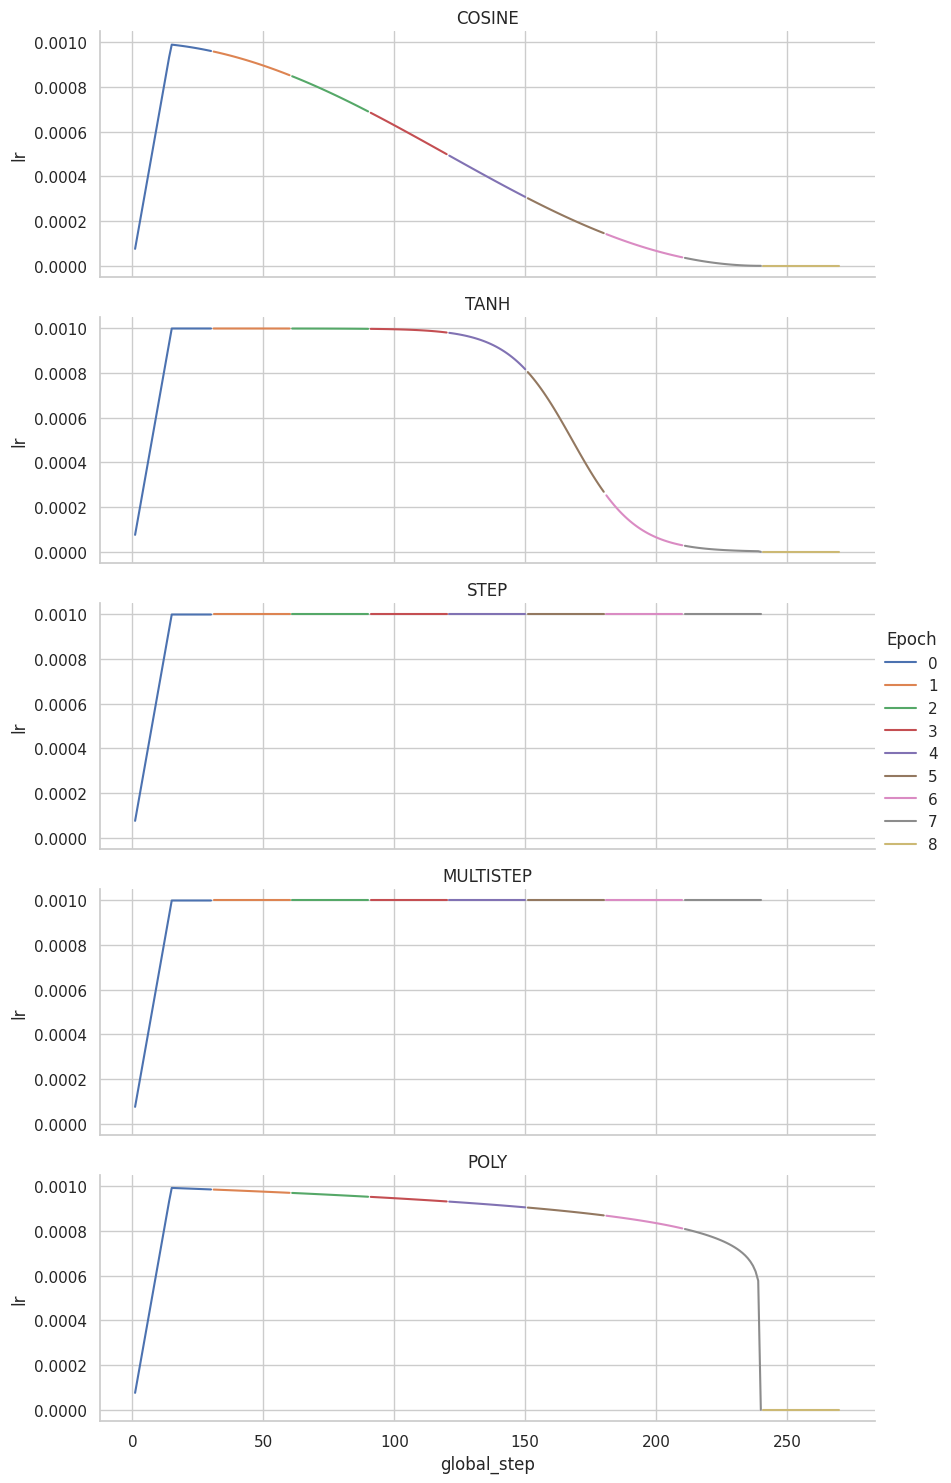

In [1]:
import unipercept as up
import torch.nn as nn
import torch.optim
from timm.scheduler.scheduler import Scheduler as TimmScheduler
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

scheduled_epochs = 8
updates_per_epoch = 30


def _read_lr(optimizer) -> float:
    return float(optimizer.param_groups[0]["lr"])


df_rows = []

for scd in up.engine.SchedType:
    model = nn.Linear(20, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler_factory = up.engine.SchedulerFactory(
        scd, warmup_epochs=0.5, cooldown_epochs=1
    )
    try:
        scheduler, epoch_amount = scheduler_factory(
            optimizer, scheduled_epochs, updates_per_epoch=updates_per_epoch
        )
        global_steps = 0
        for epoch in range(epoch_amount):
            for step in range(updates_per_epoch):
                global_steps += 1
                scheduler.step_update(global_steps, None)
                df_rows.append(
                    {
                        "name": scd.name,
                        "global_step": global_steps,
                        "epoch": epoch,
                        "step": step,
                        "lr": _read_lr(optimizer),
                    }
                )
            scheduler.step(epoch, None)

    except Exception as err:
        pass

df = pd.DataFrame(df_rows)

g = sns.FacetGrid(
    df,
    hue="epoch",
    col="name",
    col_wrap=1,
    height=3,
    aspect=3,
    sharex=True,
    sharey=True,
    margin_titles=True,
    legend_out=True,
)
g.set_titles(col_template="{col_name}")
g.map(sns.lineplot, "global_step", "lr")
g.add_legend(title="Epoch")

plt.show()